In [2]:
#https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

#Set seeds to make the experiment more reproducible
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

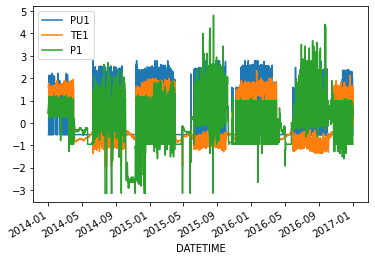

In [3]:
# https://blog.naver.com/chromatic_365/222657670527
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymysql
import matplotlib as mpl

# mysql db 연동
db = pymysql.connect(host='127.0.0.1',password='gkftndlTek!!',user='root',db='tp',charset='utf8', 
    cursorclass=pymysql.cursors.DictCursor)

cursor = db.cursor()

query = "select DATETIME, PU1, TE1, P1 from wholeData where DATETIME between '2014-01-01 00:00:00' and '2016-12-31 23:00:00'"
cursor.execute(query)
db_export = cursor.fetchall()

tp=pd.DataFrame(db_export)
#db_result_df = db_result_df.drop([db_result_df.columns[0]], axis=1) # 중복 index열 삭제

# scaling
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df
scale_columns = ['PU1', 'TE1', 'P1']

tp_df=standard_scaling(tp, scale_columns)
tp_df

tp_df.index=tp_df['DATETIME']
tp_df.set_index('DATETIME', inplace=True)
tp_df.plot()
plt.show()

# 5. Train/Valudation Split
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리한다.
# 'PU1'를 제외한 칼럼들은 x
x=tp_df[tp_df.columns.difference(['TE1'])]

y=tp_df['TE1']

# 검증(test)는 20%로 한다. = test_size=0.4
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.4,random_state=19)

In [4]:
print('Train set shape', X_train.shape)
print('Test set shape',X_test.shape)

Train set shape (15758, 2)
Test set shape (10506, 2)


In [5]:
# 40번 반복학습하고, 한번에 256개씩 학습하며, learning rate는 0.0003으로 설정
# optimizer는 adam을 사용
epochs=40
batch=256
lr=0.0003
adam=optimizers.Adam(lr)

# Model Architecture
model_mlp=Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse',optimizer=adam)

In [6]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [7]:
mlp_history=model_mlp.fit(X_train.values,y_train,epochs=epochs,verbose=2)

mlp_train_pred=model_mlp.predict(X_train.values)
mlp_test_pred=model_mlp.predict(X_test.values)

Y_train=pd.DataFrame({'y_true':y_train,'y_pred':
                     mlp_train_pred.reshape(mlp_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train=pd.merge(Y_train,tp_df,left_index=True,right_index=True,how='left')

Y_test=pd.DataFrame({'y_true':y_test,'y_pred':
                     mlp_test_pred.reshape(mlp_test_pred.shape[0],)}).set_index(X_test.index).sort_index()
Y_test=pd.merge(Y_test,tp_df,left_index=True,right_index=True,how='left')

Epoch 1/40
493/493 - 1s - loss: 0.8436 - 700ms/epoch - 1ms/step
Epoch 2/40
493/493 - 0s - loss: 0.7713 - 344ms/epoch - 698us/step
Epoch 3/40
493/493 - 0s - loss: 0.7358 - 338ms/epoch - 686us/step
Epoch 4/40
493/493 - 0s - loss: 0.7139 - 340ms/epoch - 690us/step
Epoch 5/40
493/493 - 0s - loss: 0.7000 - 345ms/epoch - 700us/step
Epoch 6/40
493/493 - 0s - loss: 0.6895 - 350ms/epoch - 710us/step
Epoch 7/40
493/493 - 0s - loss: 0.6816 - 350ms/epoch - 710us/step
Epoch 8/40
493/493 - 0s - loss: 0.6753 - 347ms/epoch - 704us/step
Epoch 9/40
493/493 - 0s - loss: 0.6715 - 343ms/epoch - 696us/step
Epoch 10/40
493/493 - 0s - loss: 0.6680 - 341ms/epoch - 692us/step
Epoch 11/40
493/493 - 0s - loss: 0.6659 - 340ms/epoch - 690us/step
Epoch 12/40
493/493 - 0s - loss: 0.6637 - 342ms/epoch - 693us/step
Epoch 13/40
493/493 - 0s - loss: 0.6633 - 338ms/epoch - 686us/step
Epoch 14/40
493/493 - 0s - loss: 0.6620 - 341ms/epoch - 692us/step
Epoch 15/40
493/493 - 0s - loss: 0.6611 - 341ms/epoch - 692us/step
Epoch 

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymysql
import matplotlib as mpl
from sklearn import metrics

def scoring(y_true,y_pred):
    r2=round(metrics.r2_score(y_true,y_pred)*100,3)
    
    corr=round(np.corrcoef(y_true,y_pred)[0,1],3)
    mape=round(metrics.mean_absolute_percentage_error(y_true,y_pred)*100,3)
    rmse=round(metrics.mean_squared_error(y_true,y_pred,squared=False),3)
    
    df=pd.DataFrame({
        'R2':r2,
        "Corr":corr,
        "RMSE":rmse,
        "MAPE":mape
    },
    index=[0])
    return df

In [9]:
scoring(Y_train.y_true,Y_train.y_pred)

,R2,Corr,RMSE,MAPE
0,34.173,0.585,0.811,99.581


In [10]:
scoring(Y_test.y_true,Y_test.y_pred)

,R2,Corr,RMSE,MAPE
0,33.727,0.581,0.814,89.438


In [35]:
temp=Y_test.loc[(Y_test.PU1<=1)&(Y_test.TE1>=-1)&(Y_test.P1>=0),].sort_values('DATETIME')
#temp=Y_test.sort_values('DATETIME')
print("Obs of Test Set :",temp.shape[0])

Obs of Test Set : 3383


In [36]:
def abline(slope,intercept):
    axes=plt.gca()
    x_vals=np.array(axes.get_xlim())
    y_vals=intercept+slope*x_vals
    plt.plot(x_vals,y_vals,'--')
    
def MinMax(y_true,y_pred,m="min"):
    if(m=="min"):
        return min(min(y_true),min(y_pred))-2
    else:
        return max(max(y_true),max(y_pred))+2
    
def myGraph(temp,title,index):
    fig,axs=plt.subplots(1,2,figsize=(17,4))

    axs[0].plot(temp.index,temp.y_true,label="Original")
    axs[0].plot(temp.index,temp.y_pred,label="Predicted")
    
    axs[0].legend(loc='upper right')
    axs[0].title.set_text('TE1_predicted')
    axs[0].set_xlabel("DATETIME")
    axs[0].set_ylabel("TE1")
    
    axs[1].plot(temp.y_true,temp.y_pred,'.')
    
    plt.xlim(MinMax(temp.y_true,temp.y_pred),MinMax(temp.y_true,temp.y_pred,"max"))

    plt.ylim(MinMax(temp.y_true,temp.y_pred),MinMax(temp.y_true,temp.y_pred,"max"))
    abline(1,0)
    plt.title('TE1_predicted')
    plt.xlabel("Original")
    plt.ylabel("Predicted")

    plt.show()

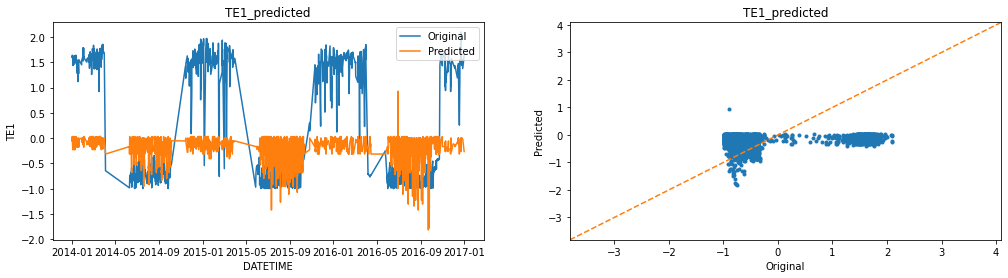

In [37]:
myGraph(temp,'hi','DATETIME')

In [38]:
temp

,y_true,y_pred,PU1,TE1,P1
DATETIME,,,,,
2014-01-01 01:00:00,1.606523,-0.055727,-0.522399,1.606523,0.427554
2014-01-01 02:00:00,1.592964,-0.055727,-0.522399,1.592964,0.427554
2014-01-01 03:00:00,1.606523,0.031605,-0.522399,1.606523,0.590019
2014-01-01 07:00:00,1.606523,0.031605,-0.522399,1.606523,0.590019
2014-01-01 11:00:00,1.606523,-0.023542,-0.522399,1.606523,0.752483
...,...,...,...,...,...
2016-12-22 06:00:00,2.094654,0.001173,-0.522399,2.094654,0.508787
2016-12-23 21:00:00,1.443813,0.001173,-0.522399,1.443813,0.508787
2016-12-25 07:00:00,1.565846,0.004031,-0.522399,1.565846,0.671251
